# Contact Classification

Download data from: https://utexas.box.com/s/5tvy96e01yett9kqdu5htdsvn9q6dtyc  
_Requires a UT account_  
Place the downloaded data in a folder `data/`

## Import statements

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import re

## Parse data

### Read files

In [2]:
file_pattern = "*.csv"
data_path = os.fspath("data/oct30")
data_files = glob.glob(file_pattern, root_dir=data_path)

# excluded_test_ids = {""}
excluded_test_ids = set()

print(f"Found {len(data_files)} data files")
test_id_set = set()
for file_name in data_files:
    file_prefix = file_name.split("_")[0]
    test_id_set.add(file_prefix)
for test_id in test_id_set:
    if test_id in excluded_test_ids:
        print(f"Unique Test ID: {test_id} : Excluded from test sets")
    else:
        print(f"Unique Test ID: {test_id} : Included in test sets")


Found 25 data files
Unique Test ID: rp2 : Included in test sets
Unique Test ID: lp0 : Included in test sets
Unique Test ID: rp1 : Included in test sets
Unique Test ID: rpf : Included in test sets
Unique Test ID: lp2 : Included in test sets
Unique Test ID: rp0 : Included in test sets
Unique Test ID: lp1 : Included in test sets
Unique Test ID: lpf : Included in test sets


### Append data files to Pandas dataframe

In [3]:
df_list = []
for file_name in data_files:
    file_prefix = file_name.split("_")[0]
    file = os.path.join(data_path, file_name)
    temp_df = pd.read_csv(file)
    temp_df.insert(0,"test_id",file_prefix)
    df_list.append(temp_df)
data_raw = pd.concat(df_list)
display(data_raw)
display(data_raw.dtypes)

,test_id,Time (s.ms),Force_gauge (N),Linear_position (mm),strain_0.0800m (µε),strain_1.2841m (µε),strain_0.0800m (µε).1,strain_0.0807m (µε),strain_0.0813m (µε),strain_0.0820m (µε),...,strain_1.2799m (µε),strain_1.2806m (µε),strain_1.2812m (µε),strain_1.2818m (µε),strain_1.2825m (µε),strain_1.2831m (µε),strain_1.2838m (µε),strain_1.2845m (µε),strain_1.2851m (µε),strain_1.2858m (µε)
0,lp0,42.886,0.0,-1.074219,-12.9,-1.0,-12.9,3.400000,-6.800001,-8.500000,...,-2.500000,-11.499999,1.299999,1.9,-10.200001,-9.6,-2.5,-4.0,-1.900001,-1.0
1,lp0,43.171,0.0,-1.048584,-0.6,0.8,-0.6,-1.600000,-10.800001,3.900000,...,-2.500000,-16.899999,-11.600000,-5.8,-0.400002,-5.1,9.5,1.3,-14.900000,0.8
2,lp0,43.449,0.0,-1.021729,-10.3,-6.0,-10.3,12.100001,-2.000001,14.100000,...,5.700001,-15.999999,-20.200000,-11.6,-6.100000,-11.6,10.7,5.2,-8.300000,-6.0
3,lp0,43.766,0.0,-0.995361,-4.9,11.5,-4.9,-1.300000,-2.400001,8.100000,...,0.600000,-9.199999,-21.000000,1.1,-10.400001,-6.5,10.2,15.3,4.700000,11.5
4,lp0,44.062,0.0,-0.989502,-7.3,5.1,-7.3,1.800000,-6.800001,2.700000,...,0.200000,-6.900000,0.699999,-7.1,-5.300001,-9.6,-14.5,-6.7,-6.400000,5.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,rpf,38.734,0.0,3.550781,-4.2,-6.9,-4.2,-5.900000,13.800000,18.199999,...,6.200000,1.000000,32.900002,11.7,-2.000000,-11.6,-2.9,1.9,-2.400000,-6.9
119,rpf,38.988,0.0,3.575928,0.0,-8.9,0.0,-6.900000,-7.600000,8.299999,...,10.099999,-12.100000,3.700000,-3.7,-7.400000,-10.8,6.1,1.4,-3.000000,-8.9
120,rpf,39.241,0.0,3.600586,3.1,-11.8,3.1,-1.900000,4.200000,-5.400000,...,-8.400000,-6.500001,5.700000,5.1,-7.100000,-23.3,-8.8,-10.5,-7.100000,-11.8
121,rpf,39.510,0.0,3.625000,-10.9,-7.4,-10.9,-10.000000,-1.500000,0.000000,...,-0.400001,7.199999,11.900000,16.6,-2.000000,-14.5,-9.8,-9.9,-16.200000,-7.4


test_id                  object
Time (s.ms)             float64
Force_gauge (N)         float64
Linear_position (mm)    float64
strain_0.0800m (µε)     float64
                         ...   
strain_1.2831m (µε)     float64
strain_1.2838m (µε)     float64
strain_1.2845m (µε)     float64
strain_1.2851m (µε)     float64
strain_1.2858m (µε)     float64
Length: 1862, dtype: object

### Remove extra gauges and sort by position along sensor

In [4]:
data = data_raw.loc[:, ~data_raw.columns.str.contains(r"\.\d+$")]

strain_cols = [col for col in data.columns if col.startswith("strain")]
other_cols = [col for col in data.columns if col not in strain_cols]

x_axis_raw = np.array([float(re.search(r"strain_(.*)m", x).group(1)) for x in strain_cols])
sorted_idx = np.argsort(x_axis_raw)
x_axis = np.sort(x_axis_raw)
sorted_strain_cols = [strain_cols[i] for i in sorted_idx]
data = data[other_cols + sorted_strain_cols]
display(data)

,test_id,Time (s.ms),Force_gauge (N),Linear_position (mm),strain_0.0800m (µε),strain_0.0807m (µε),strain_0.0813m (µε),strain_0.0820m (µε),strain_0.0826m (µε),strain_0.0833m (µε),...,strain_1.2806m (µε),strain_1.2812m (µε),strain_1.2818m (µε),strain_1.2825m (µε),strain_1.2831m (µε),strain_1.2838m (µε),strain_1.2841m (µε),strain_1.2845m (µε),strain_1.2851m (µε),strain_1.2858m (µε)
0,lp0,42.886,0.0,-1.074219,-12.9,3.400000,-6.800001,-8.500000,8.400001,4.300000,...,-11.499999,1.299999,1.9,-10.200001,-9.6,-2.5,-1.0,-4.0,-1.900001,-1.0
1,lp0,43.171,0.0,-1.048584,-0.6,-1.600000,-10.800001,3.900000,2.300000,2.500000,...,-16.899999,-11.600000,-5.8,-0.400002,-5.1,9.5,0.8,1.3,-14.900000,0.8
2,lp0,43.449,0.0,-1.021729,-10.3,12.100001,-2.000001,14.100000,9.200000,-8.400000,...,-15.999999,-20.200000,-11.6,-6.100000,-11.6,10.7,-6.0,5.2,-8.300000,-6.0
3,lp0,43.766,0.0,-0.995361,-4.9,-1.300000,-2.400001,8.100000,12.099999,-12.600000,...,-9.199999,-21.000000,1.1,-10.400001,-6.5,10.2,11.5,15.3,4.700000,11.5
4,lp0,44.062,0.0,-0.989502,-7.3,1.800000,-6.800001,2.700000,17.400001,3.600000,...,-6.900000,0.699999,-7.1,-5.300001,-9.6,-14.5,5.1,-6.7,-6.400000,5.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,rpf,38.734,0.0,3.550781,-4.2,-5.900000,13.800000,18.199999,15.699999,-2.700000,...,1.000000,32.900002,11.7,-2.000000,-11.6,-2.9,-6.9,1.9,-2.400000,-6.9
119,rpf,38.988,0.0,3.575928,0.0,-6.900000,-7.600000,8.299999,15.199999,8.500000,...,-12.100000,3.700000,-3.7,-7.400000,-10.8,6.1,-8.9,1.4,-3.000000,-8.9
120,rpf,39.241,0.0,3.600586,3.1,-1.900000,4.200000,-5.400000,2.400000,3.700001,...,-6.500001,5.700000,5.1,-7.100000,-23.3,-8.8,-11.8,-10.5,-7.100000,-11.8
121,rpf,39.510,0.0,3.625000,-10.9,-10.000000,-1.500000,0.000000,4.299999,0.100000,...,7.199999,11.900000,16.6,-2.000000,-14.5,-9.8,-7.4,-9.9,-16.200000,-7.4


## Data Processing

### Visualize strain ranges

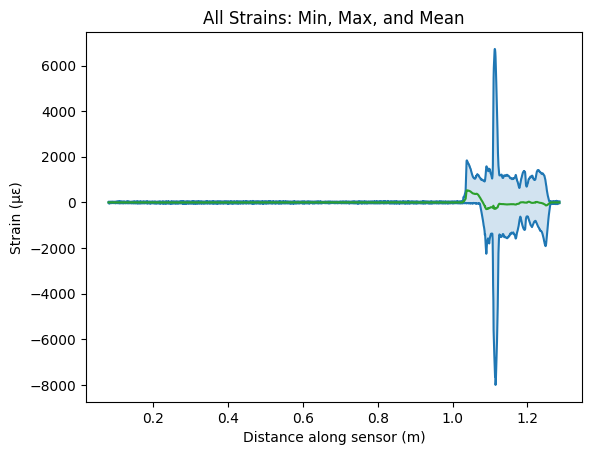

In [5]:
upper_bound = data[sorted_strain_cols].max()
lower_bound = data[sorted_strain_cols].min()
mean_line = data[sorted_strain_cols].mean()

fig, ax = plt.subplots()
ax.plot(x_axis,upper_bound,color='tab:blue')
ax.plot(x_axis,lower_bound,color='tab:blue')
ax.plot(x_axis,mean_line,color='tab:green')
ax.fill_between(x_axis,upper_bound,lower_bound,alpha=0.2)
ax.set_title("All Strains: Min, Max, and Mean")
ax.set_ylabel("Strain (με)")
ax.set_xlabel("Distance along sensor (m)")
plt.show()

### Cutoff excess early data

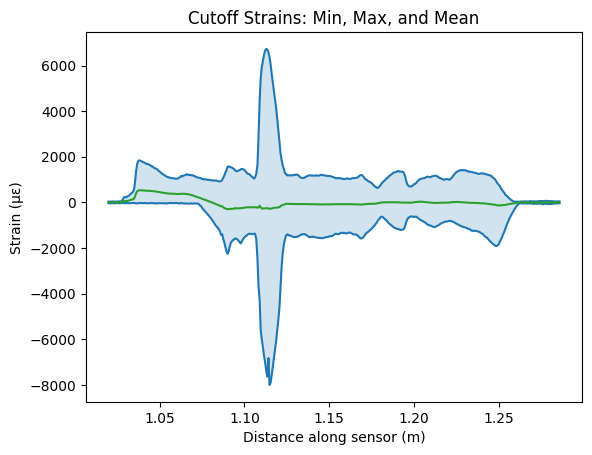

In [6]:
start_location = 1.02
cutoff_idx = (np.abs(x_axis - start_location)).argmin()
cutoff_strain = data[sorted_strain_cols].iloc[:,cutoff_idx:]
cutoff_x_axis = x_axis[cutoff_idx:]

upper_bound = cutoff_strain.max()
lower_bound = cutoff_strain.min()
mean_line = cutoff_strain.mean()

fig, ax = plt.subplots()
ax.plot(cutoff_x_axis,upper_bound,color='tab:blue')
ax.plot(cutoff_x_axis,lower_bound,color='tab:blue')
ax.plot(cutoff_x_axis,mean_line,color='tab:green')
ax.fill_between(cutoff_x_axis,upper_bound,lower_bound,alpha=0.2)
ax.set_title("Cutoff Strains: Min, Max, and Mean")
ax.set_ylabel("Strain (με)")
ax.set_xlabel("Distance along sensor (m)")
plt.show()

### Remove NAN values

In [7]:
display(cutoff_strain.isna().sum().sum())
cutoff_strain.interpolate(inplace=True, axis=0)
cutoff_strain.interpolate(inplace=True, axis=1)
display(cutoff_strain.isna().sum().sum())


np.int64(3775)

np.int64(0)

### Create classification labels

In [8]:
force_threshold = 0.01
contact_data = pd.DataFrame({"Contact": (data['Force_gauge (N)'] >= force_threshold).astype(int)})
display(contact_data.sum(axis=0))
data = pd.concat([data, contact_data],axis=1)

Contact    566
dtype: int64

## Train Model

### Create custom cross-validation splits

In [9]:
cv_split_array = np.zeros(len(data.test_id))
test_id_array = data.test_id.to_numpy()
i = 0
test_id_names = []
for test_id in test_id_set:
    if test_id in excluded_test_ids:
        split_idx = -1
    else:
        split_idx = i
        test_id_names.append(test_id)
        i += 1
    cv_split_array = np.where(test_id_array == test_id, split_idx, cv_split_array)
print(f"Generated {i} test sets")
print(f"{data["test_id"].value_counts()}")
for test_id in test_id_names:
    test_id_rows = data.loc[data['test_id'] == test_id]
    print(f"{test_id} Total contacts: {test_id_rows["Contact"].sum().sum()}")
print(data["Contact"].sum())

Generated 8 test sets
test_id
lpf    443
lp1    388
rpf    377
rp1    319
lp2    301
lp0    281
rp0    271
rp2    256
Name: count, dtype: int64
rp2 Total contacts: 114
lp0 Total contacts: 134
rp1 Total contacts: 62
rpf Total contacts: 0
lp2 Total contacts: 81
rp0 Total contacts: 96
lp1 Total contacts: 79
lpf Total contacts: 0
566


### Train Classification Model

In [10]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import PredefinedSplit
model = GradientBoostingClassifier()
parameters = {
    "learning_rate":[]
}
folds = PredefinedSplit(cv_split_array)
scores = cross_validate(model, cutoff_strain, contact_data.to_numpy().squeeze(), 
                        cv=folds, scoring=['precision','recall','roc_auc'], n_jobs = -1)

score_df = pd.DataFrame(scores)

In [11]:
score_df = pd.DataFrame(scores)
score_df["test_set_id"] = test_id_names
display(score_df)

,fit_time,score_time,test_precision,test_recall,test_roc_auc,test_set_id
0,25.750460,0.008516,1.00000,0.631579,0.991413,rp2
1,25.524734,0.006999,1.00000,0.820896,0.987740,lp0
2,24.992426,0.005999,1.00000,0.080645,0.882610,rp1
3,24.255497,0.007998,0.00000,0.000000,NaN,rpf
4,25.401660,0.007010,1.00000,0.777778,0.982127,lp2
5,25.529734,0.008002,1.00000,0.510417,0.981815,rp0
6,24.267498,0.008572,0.87037,0.594937,0.931977,lp1
7,23.787206,0.036077,0.00000,0.000000,NaN,lpf


In [12]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_validate, KFold

regressor = GradientBoostingRegressor()
y_force = data['Force_gauge (N)']
y_force.fillna(0, inplace=True)
scores = cross_validate(regressor, cutoff_strain, y_force, 
                        cv=folds, scoring=['neg_mean_absolute_error','r2'], n_jobs = -1)

print("MAE scores:", -scores['test_neg_mean_absolute_error'])
print("R2 scores:", scores['test_r2'])

MAE scores: [0.02501268 0.01260148 0.00740459 0.02346024 0.01170687 0.00807626
 0.00731293 0.01152649]
R2 scores: [0.19650274 0.80423401 0.8185358  0.         0.70763902 0.90625912
 0.89010504 0.        ]


In [13]:
score_df = pd.DataFrame(scores)
score_df["test_set_id"] = test_id_names
display(score_df)

,fit_time,score_time,test_neg_mean_absolute_error,test_r2,test_set_id
0,24.969483,0.003000,-0.025013,0.196503,rp2
1,24.880959,0.002998,-0.012601,0.804234,lp0
2,24.197037,0.002997,-0.007405,0.818536,rp1
3,23.692430,0.002998,-0.023460,0.000000,rpf
4,24.561494,0.002999,-0.011707,0.707639,lp2
5,24.766681,0.003000,-0.008076,0.906259,rp0
6,23.646863,0.002999,-0.007313,0.890105,lp1
7,23.101504,0.003999,-0.011526,0.000000,lpf
